# Music Popularity Predictive Model
Author: Carlos Garza

## Overview
This notebook details the building, tuning, and deployment of a model that predicts a song's popularity on spotify.

## Business Problem
In the music industry, an important metric that has surfaced in the last few years is an artist's Spotify numbers. Many entities in the industry, from venues to record labels, will check an artist's spotify numbers before choosing to work with or book them and, for better or worse, will base their decision in part on the artist's performance on the platform.

This increase in Spotify metric importance has opened opportunities for optimization in the pop and Nashville country music workflow. Typically, a producer or songwriter will rent studio time and hire studio musicians to produce singles that can then be pitched to artists. Artists buy these songs and rerecord them with their own studio teams to be released as singles or as part of a record. 

If producers had a model that they could use to evaluate their music while in the production and could deliver a model's predictions while pitching music, they would have a new edge in the industry.

## Data
The data for this project originates from the Spotify API. The data used for this model training was organized and uploaded to Kaggle by user Yamac Eren Ay, and can be found [here](https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks?select=data.csv).

The data describes 174,389 songs. Specifics features of the data are explored below.

In [1]:
# import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# import data
df = pd.read_csv('data/data.csv')
df.head()

acousticness                    artists  danceability  duration_ms  energy  \
0      0.991000            ['Mamie Smith']         0.598       168333   0.224   
1      0.643000  ["Screamin' Jay Hawkins"]         0.852       150200   0.517   
2      0.993000            ['Mamie Smith']         0.647       163827   0.186   
3      0.000173        ['Oscar Velazquez']         0.730       422087   0.798   
4      0.295000                   ['Mixe']         0.704       165224   0.707   

   explicit                      id  instrumentalness  key  liveness  \
0         0  0cS0A1fUEUd1EW3FcF8AEI          0.000522    5    0.3790   
1         0  0hbkKFIJm7Z05H8Zl9w30f          0.026400    5    0.0809   
2         0  11m7laMUgmOKqI3oYzuhne          0.000018    0    0.5190   
3         0  19Lc5SfJJ5O1oaxY0fpwfh          0.801000    2    0.1280   
4         1  2hJjbsLCytGsnAHfdsLejp          0.000246   10    0.4020   

   loudness  mode                                               name  \
0   -12.628     0                           Keep A Song In Your Soul   
1    -7.261     0                               I Put A Spell On You   
2   -12.098     1                                       Golfing Papa   
3    -7.311     1  True House Music - Xavier Santos & Carlos Gomi...   
4    -6.036     0                                          Xuniverxe   

   popularity release_date  speechiness    tempo  valence  year  
0          12         1920       0.0936  149.976   0.6340  1920  
1           7   1920-01-05       0.0534   86.889   0.9500  1920  
2           4         1920       0.1740   97.600   0.6890  1920  
3          17   1920-01-01       0.0425  127.997   0.0422  1920  
4           2   1920-10-01       0.0768  122.076   0.2990  1920

### EDA
Before processing any data, the data will be visualized so any missing or outlier data can be managed.

The overview of the dataframe shows that there are no missing values. However, the ```id``` column can be dropped as it points to specific songs rather than quantifying song details. Also, the ```release_date``` column only holds month and day data for some rows. The rest of the rows only show release year, which is redundant to the info in the ```year``` column, and can therefore be dropped. 

In [3]:
# View dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174389 entries, 0 to 174388
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   acousticness      174389 non-null  float64
 1   artists           174389 non-null  object 
 2   danceability      174389 non-null  float64
 3   duration_ms       174389 non-null  int64  
 4   energy            174389 non-null  float64
 5   explicit          174389 non-null  int64  
 6   id                174389 non-null  object 
 7   instrumentalness  174389 non-null  float64
 8   key               174389 non-null  int64  
 9   liveness          174389 non-null  float64
 10  loudness          174389 non-null  float64
 11  mode              174389 non-null  int64  
 12  name              174389 non-null  object 
 13  popularity        174389 non-null  int64  
 14  release_date      174389 non-null  object 
 15  speechiness       174389 non-null  float64
 16  tempo             17

In [4]:
# drop unnecessary columns
to_drop = ['id', 'release_date']
df.drop(to_drop, axis=1, inplace=True)

Moving forward, it is useful to separate the dataframe into continuous and categorical columns for further analysis.

In [5]:
# split df columns into categorical and continuous columns
cat_columns = ['artists', 'explicit', 'key', 'mode', 'name']
cont_columns = ['acousticness', 'danceability', 'duration_ms',
                'energy', 'instrumentalness', 'liveness',
                'loudness', 'popularity', 'speechiness',
                'tempo', 'valence', 'year']

In [6]:
# create continuous df and categorical df
cont_df = df[cont_columns]
cat_df = df[cont_columns]
cont_df.head()

acousticness  danceability  duration_ms  energy  instrumentalness  \
0      0.991000         0.598       168333   0.224          0.000522   
1      0.643000         0.852       150200   0.517          0.026400   
2      0.993000         0.647       163827   0.186          0.000018   
3      0.000173         0.730       422087   0.798          0.801000   
4      0.295000         0.704       165224   0.707          0.000246   

   liveness  loudness  popularity  speechiness    tempo  valence  year  
0    0.3790   -12.628          12       0.0936  149.976   0.6340  1920  
1    0.0809    -7.261           7       0.0534   86.889   0.9500  1920  
2    0.5190   -12.098           4       0.1740   97.600   0.6890  1920  
3    0.1280    -7.311          17       0.0425  127.997   0.0422  1920  
4    0.4020    -6.036           2       0.0768  122.076   0.2990  1920

In [7]:
cat_df.head()

acousticness  danceability  duration_ms  energy  instrumentalness  \
0      0.991000         0.598       168333   0.224          0.000522   
1      0.643000         0.852       150200   0.517          0.026400   
2      0.993000         0.647       163827   0.186          0.000018   
3      0.000173         0.730       422087   0.798          0.801000   
4      0.295000         0.704       165224   0.707          0.000246   

   liveness  loudness  popularity  speechiness    tempo  valence  year  
0    0.3790   -12.628          12       0.0936  149.976   0.6340  1920  
1    0.0809    -7.261           7       0.0534   86.889   0.9500  1920  
2    0.5190   -12.098           4       0.1740   97.600   0.6890  1920  
3    0.1280    -7.311          17       0.0425  127.997   0.0422  1920  
4    0.4020    -6.036           2       0.0768  122.076   0.2990  1920

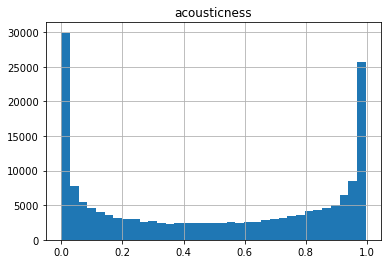

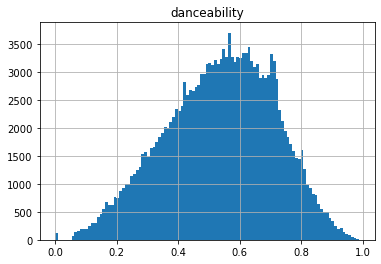

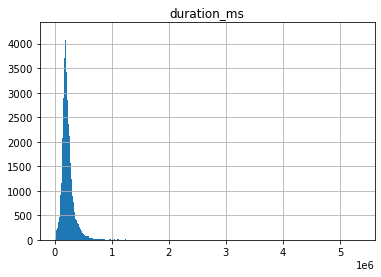

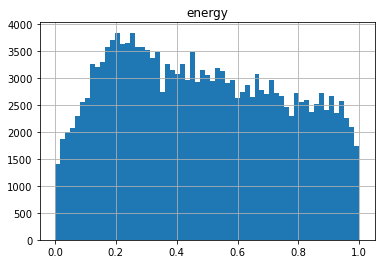

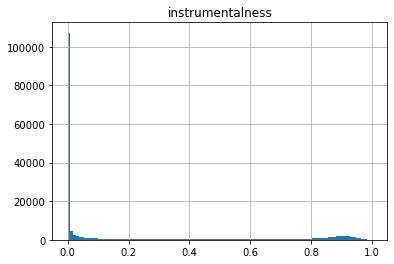

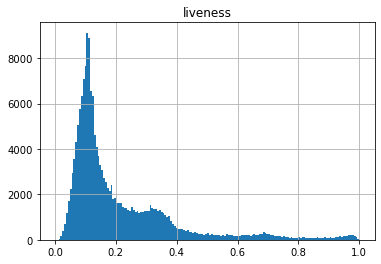

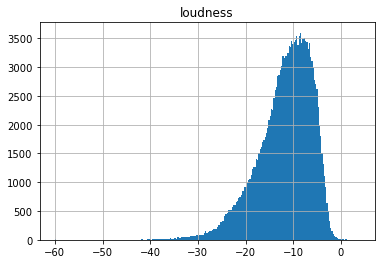

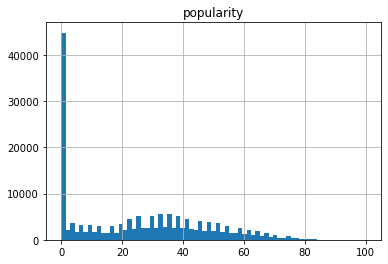

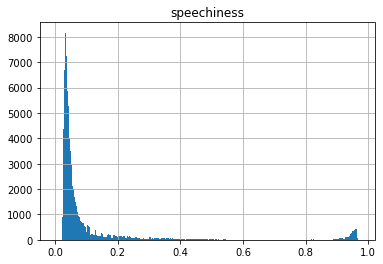

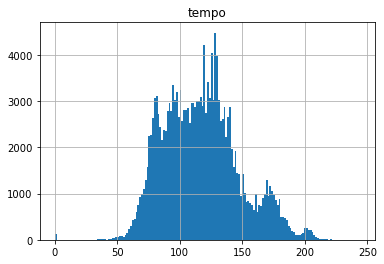

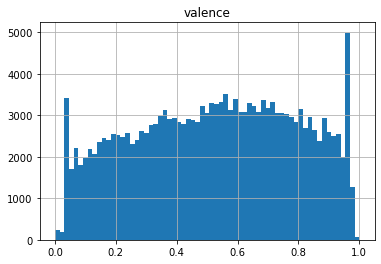

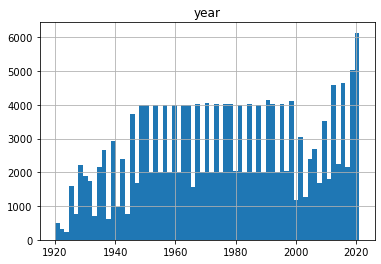

In [8]:
# view histograms of continuous variables
for column in cont_df.columns:
    plt.figure()
    cont_df[column].hist(bins='auto')
    plt.title(column)

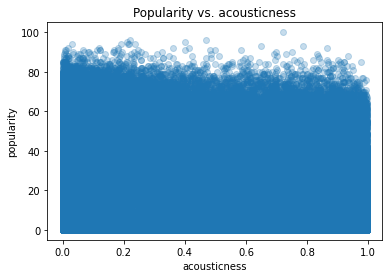

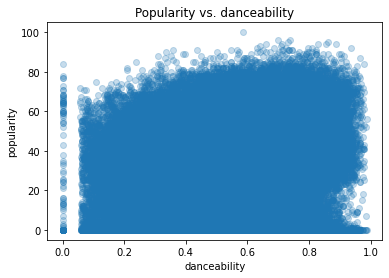

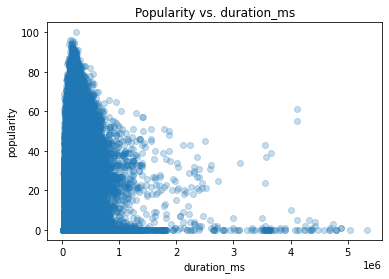

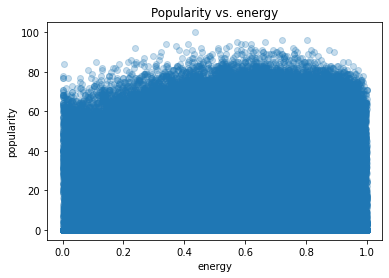

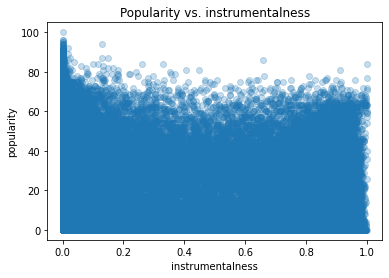

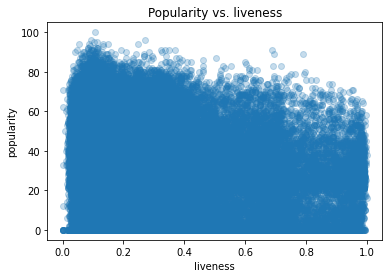

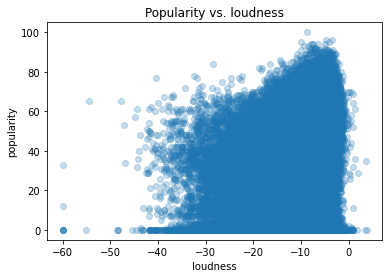

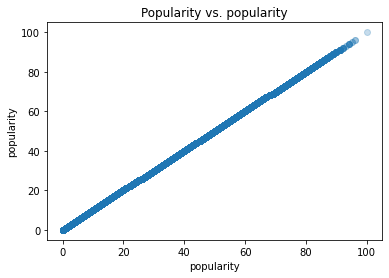

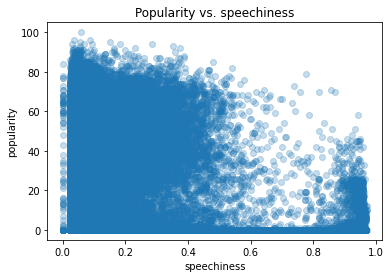

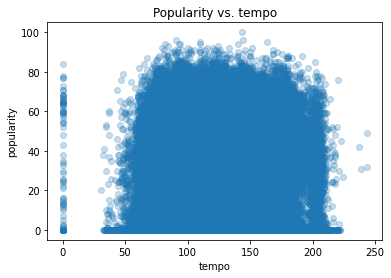

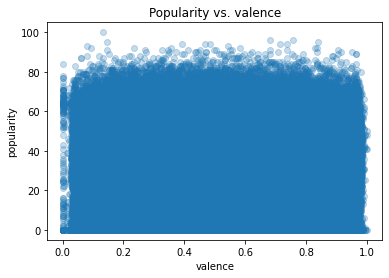

In [9]:
# view scatterplots of continuous variables vs. popularity
for column in cont_df.columns:
    plt.figure()
    plt.scatter(df[column], df.popularity, alpha=0.25)
    plt.title(f'Popularity vs. {column}')
    plt.xlabel(column)
    plt.ylabel('popularity')

In [10]:
# view value counts for categorical columns
for column in cat_columns:
    print(column, '\n')
    print(df[column].value_counts().head())
    print('------')

artists 

['Tadeusz Dolega Mostowicz']    1281
['Эрнест Хемингуэй']            1175
['Эрих Мария Ремарк']           1062
['Francisco Canaro']             951
['Ignacio Corsini']              624
Name: artists, dtype: int64
------
explicit 

0    162507
1     11882
Name: explicit, dtype: int64
------
key 

0    21967
7    21363
2    18916
9    18109
5    16546
Name: key, dtype: int64
------
mode 

1    122488
0     51901
Name: mode, dtype: int64
------
name 

White Christmas      103
Winter Wonderland     88
Silent Night          81
Jingle Bells          71
2000 Years            70
Name: name, dtype: int64
------


After reviewing the continuous and categorical data, it can be seen that ```instrumentalness``` is defaulted to ```0``` for the vast majority of the data rows. The column is questionable and is therefore dropped.

Column ```artists``` is dropped to minimize the influence of "repeat hit artists" in the model. Similarly, ```name``` is dropped because the the most popular names of songs are all holiday oriented and that correlation may affect the data in unexpected ways.

In [11]:
# drop unnecessary columns
to_drop_2 = ['name', 'artists', 'instrumentalness']
df.drop(to_drop_2, axis=1, inplace=True)

```popularity``` has a disproportionate ammount of ```0``` values, which hints at ```0``` being a default number for missing data. Those rows are removed.

There is no such thing as a song with a tempo of ```0```, so the small handful of rows with that value are dropped.

Lastly, the ```duration_ms``` outliers with songs longer than ~16 minutes are dropped.

In [12]:
# drop outliers and default values
df.drop(df[df['popularity']==0].index, inplace=True)
df.drop(df[df['tempo']==0].index, inplace=True)
df.drop(df[df['duration_ms']>1000000].index, inplace=True)

Histograms and scatterplots are rechecked.

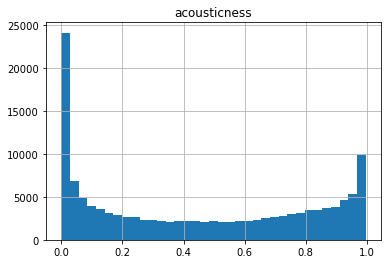

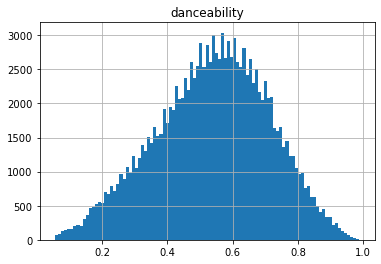

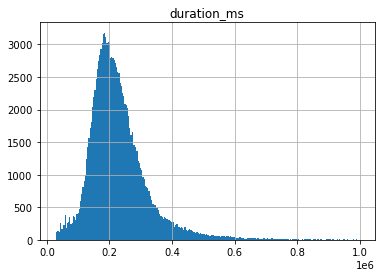

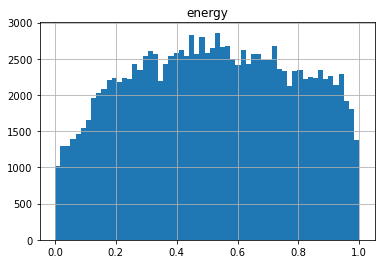

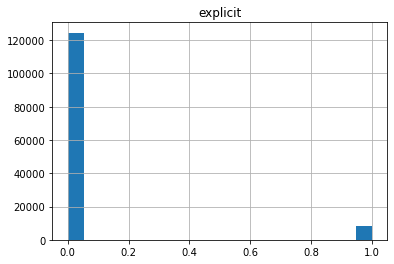

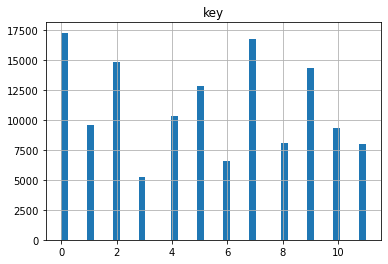

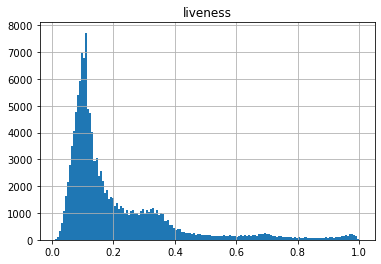

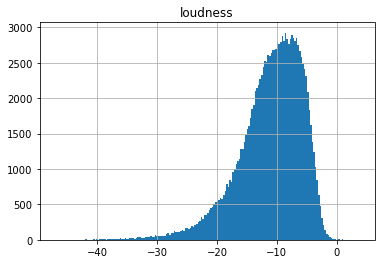

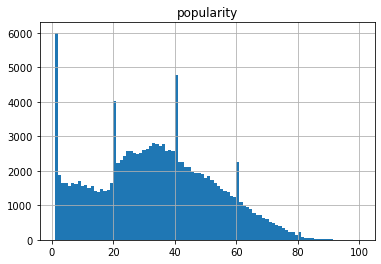

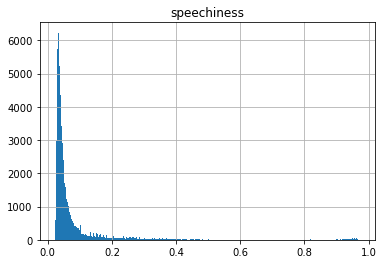

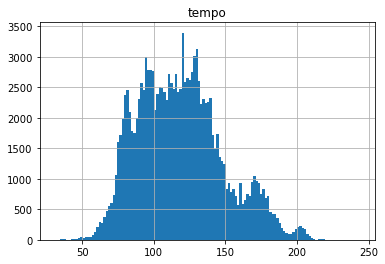

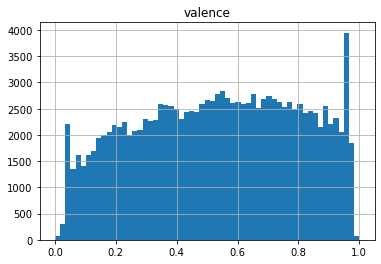

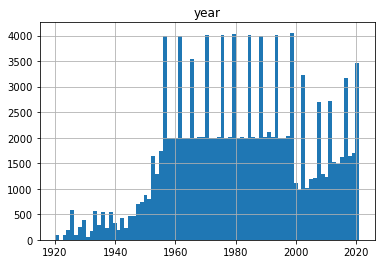

In [13]:
for column in df.columns:
    plt.figure()
    df[column].hist(bins='auto')
    plt.title(column)

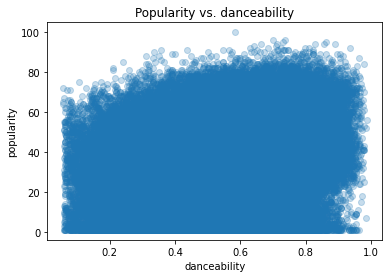

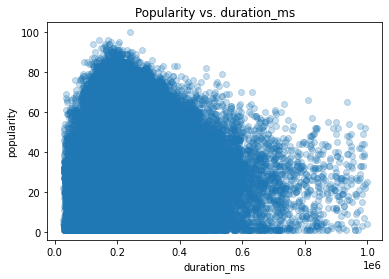

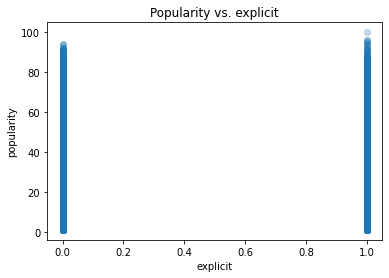

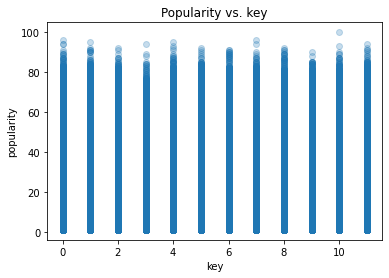

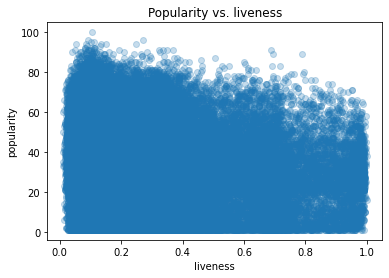

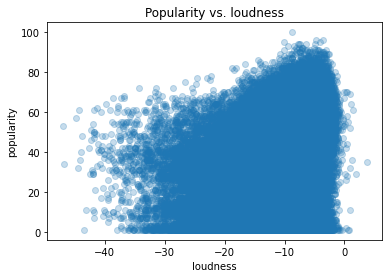

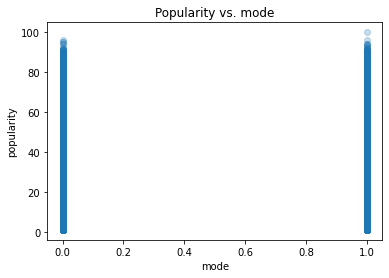

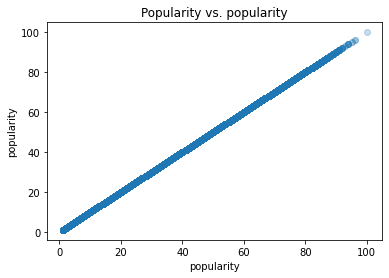

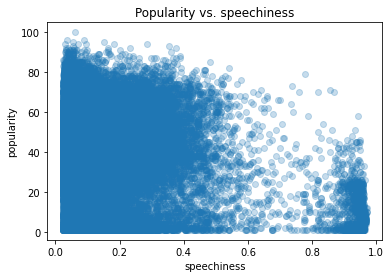

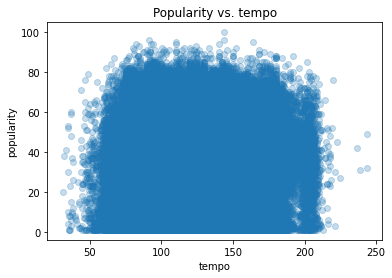

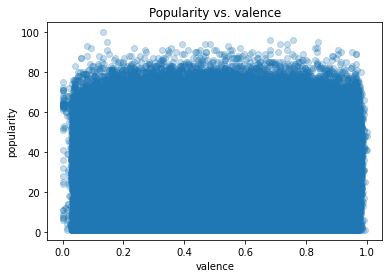

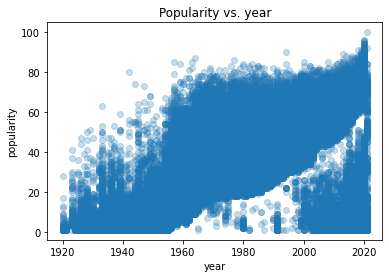

In [14]:
for column in df.columns:
    plt.figure()
    plt.scatter(df[column], df.popularity, alpha=0.25)
    plt.title(f'Popularity vs. {column}')
    plt.xlabel(column)
    plt.ylabel('popularity')

In [15]:
# check final df shape
df.shape

(133091, 14)

In [16]:
df.reset_index(inplace=True, drop=True)
df.head()

acousticness  danceability  duration_ms  energy  explicit  key  liveness  \
0      0.991000         0.598       168333   0.224         0    5    0.3790   
1      0.643000         0.852       150200   0.517         0    5    0.0809   
2      0.993000         0.647       163827   0.186         0    0    0.5190   
3      0.000173         0.730       422087   0.798         0    2    0.1280   
4      0.295000         0.704       165224   0.707         1   10    0.4020   

   loudness  mode  popularity  speechiness    tempo  valence  year  
0   -12.628     0          12       0.0936  149.976   0.6340  1920  
1    -7.261     0           7       0.0534   86.889   0.9500  1920  
2   -12.098     1           4       0.1740   97.600   0.6890  1920  
3    -7.311     1          17       0.0425  127.997   0.0422  1920  
4    -6.036     0           2       0.0768  122.076   0.2990  1920

## Data Preprocessing
Before the data can be used to train and evaluate models, it bust be split into training and test sets, the continuous variables must be normalized, and the the categorical variables must be one hot encoded.

### one hot encoding

In [17]:
# rename key column
key_names = {0:'C', 1:'C#/Db', 2:'D', 3:'D#/Eb',
             4:'E', 5:'F', 6:'F#/Gb', 7:'G',
             8:'G#/Ab', 9:'A', 10:'A#/Bb', 11:'B'}
df['key'] = df['key'].map(lambda x: key_names[x])
df.head()

acousticness  danceability  duration_ms  energy  explicit    key  liveness  \
0      0.991000         0.598       168333   0.224         0      F    0.3790   
1      0.643000         0.852       150200   0.517         0      F    0.0809   
2      0.993000         0.647       163827   0.186         0      C    0.5190   
3      0.000173         0.730       422087   0.798         0      D    0.1280   
4      0.295000         0.704       165224   0.707         1  A#/Bb    0.4020   

   loudness  mode  popularity  speechiness    tempo  valence  year  
0   -12.628     0          12       0.0936  149.976   0.6340  1920  
1    -7.261     0           7       0.0534   86.889   0.9500  1920  
2   -12.098     1           4       0.1740   97.600   0.6890  1920  
3    -7.311     1          17       0.0425  127.997   0.0422  1920  
4    -6.036     0           2       0.0768  122.076   0.2990  1920

In [18]:
# separate categorical columns for one hot encoding and create dummy variables
category_columns = ['explicit', 'key', 'mode']
category_df = pd.get_dummies(df[category_columns], drop_first=True)

In [19]:
# recombine one hot encoded variables with continuous variables
df.drop(category_columns, axis=1, inplace=True)
df = pd.concat([df, category_df], axis=1)
df.head()

acousticness  danceability  duration_ms  energy  liveness  loudness  \
0      0.991000         0.598       168333   0.224    0.3790   -12.628   
1      0.643000         0.852       150200   0.517    0.0809    -7.261   
2      0.993000         0.647       163827   0.186    0.5190   -12.098   
3      0.000173         0.730       422087   0.798    0.1280    -7.311   
4      0.295000         0.704       165224   0.707    0.4020    -6.036   

   popularity  speechiness    tempo  valence  ...  key_B  key_C  key_C#/Db  \
0          12       0.0936  149.976   0.6340  ...      0      0          0   
1           7       0.0534   86.889   0.9500  ...      0      0          0   
2           4       0.1740   97.600   0.6890  ...      0      1          0   
3          17       0.0425  127.997   0.0422  ...      0      0          0   
4           2       0.0768  122.076   0.2990  ...      0      0          0   

   key_D  key_D#/Eb  key_E  key_F  key_F#/Gb  key_G  key_G#/Ab  
0      0          0      0      1          0      0          0  
1      0          0      0      1          0      0          0  
2      0          0      0      0          0      0          0  
3      1          0      0      0          0      0          0  
4      0          0      0      0          0      0          0  

[5 rows x 24 columns]

### Train-Test Split

In [20]:
# import train test split to randomly separate data
from sklearn.model_selection import train_test_split

In [21]:
# designate independent variables X and target variable y
X = df.drop('popularity', axis=1)
y = df.popularity

In [22]:
# train test split: default test size of 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Standardization

In [23]:
# Import standard scaler
from sklearn.preprocessing import StandardScaler

In [24]:
# separate categorical and continuous columns so continuous variables can be scaled
one_hot_columns = category_df.columns

# training data
X_train_cat = X_train[one_hot_columns].reset_index(drop=True)
X_train_cont = X_train.drop(one_hot_columns, axis=1).reset_index(drop=True)

# testing data
X_test_cat = X_test[one_hot_columns].reset_index(drop=True)
X_test_cont = X_test.drop(one_hot_columns, axis=1).reset_index(drop=True)

In [25]:
# fit-transform scaler to training data and transform testing data. convert to pd dataframe
std = StandardScaler()
X_train_scaled = std.fit_transform(X_train_cont)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_cont.columns)

X_test_scaled = std.transform(X_test_cont)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_cont.columns)

In [26]:
# remerge scaled continuous variables with categorical variables
X_train = pd.concat([X_train_scaled, X_train_cat], axis=1)
X_test = pd.concat([X_test_scaled, X_test_cat], axis=1)

With the data preprocessed, it can now be used to train various machine learning models

## Baseline Models
The machine learning models that will be auditioned include a K-nearest neighbor regressor, a decision tree regressor, an XGBoost regressor, and a deep neural network. 

The models will be evaluated by their coefficient of determination andcompared by their root mean square error.

In [27]:
from sklearn.metrics import r2_score, mean_squared_error

### K Nearest Neighbor Regressor

A K nearest neighbor algorithm may be useful as it may somewhat emulate a playlisting algorithm

In [28]:
from sklearn.neighbors import KNeighborsRegressor

In [29]:
knr = KNeighborsRegressor(n_jobs=-1)
knr.fit(X_train, y_train)

KNeighborsRegressor(n_jobs=-1)

In [30]:
y_train_predict = knr.predict(X_train)
y_test_predict = knr.predict(X_test)

In [31]:
r2_score(y_test, y_test_predict)

0.4161648456545082

In [32]:
mean_squared_error(y_test, y_test_predict, squared=False)

14.467449154010987

### Decision Tree Regressor

In [33]:
from sklearn.tree import DecisionTreeRegressor

In [34]:
dtr = DecisionTreeRegressor()

In [35]:
dtr.fit(X_train, y_train)

DecisionTreeRegressor()

In [36]:
y_train_predict = dtr.predict(X_train)
y_test_predict = dtr.predict(X_test)

In [37]:
r2_score(y_test, y_test_predict)

0.1462624773665726

In [38]:
mean_squared_error(y_test, y_test_predict, squared=False)

17.494801881266103

### CGBoost Regressor

In [39]:
from xgboost import XGBRegressor

In [40]:
xgr = XGBRegressor(n_jobs=-1)

In [47]:
xgr.fit(X_train, y_train);

In [48]:
y_train_predict = xgr.predict(X_train)
y_test_predict = xgr.predict(X_test)

In [49]:
r2_score(y_test, y_test_predict)

0.5645174171264948

In [50]:
mean_squared_error(y_test, y_test_predict, squared=False)

12.494884299433291

### Deep Neural Network

## Model Tuning

## Model Evaluation

## Conclusions

## Future Work